In [94]:
pip install --user xgboost


Note: you may need to restart the kernel to use updated packages.


In [95]:
import pandas as pd
import re
import string
import collections
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import pickle

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Exploracion de datos

In [96]:
df = pd.read_csv('./Emotion_final.csv')
# df = df.drop('tweet_id', axis=1)
df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [98]:
df['Emotion'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

c:\Users\simon\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


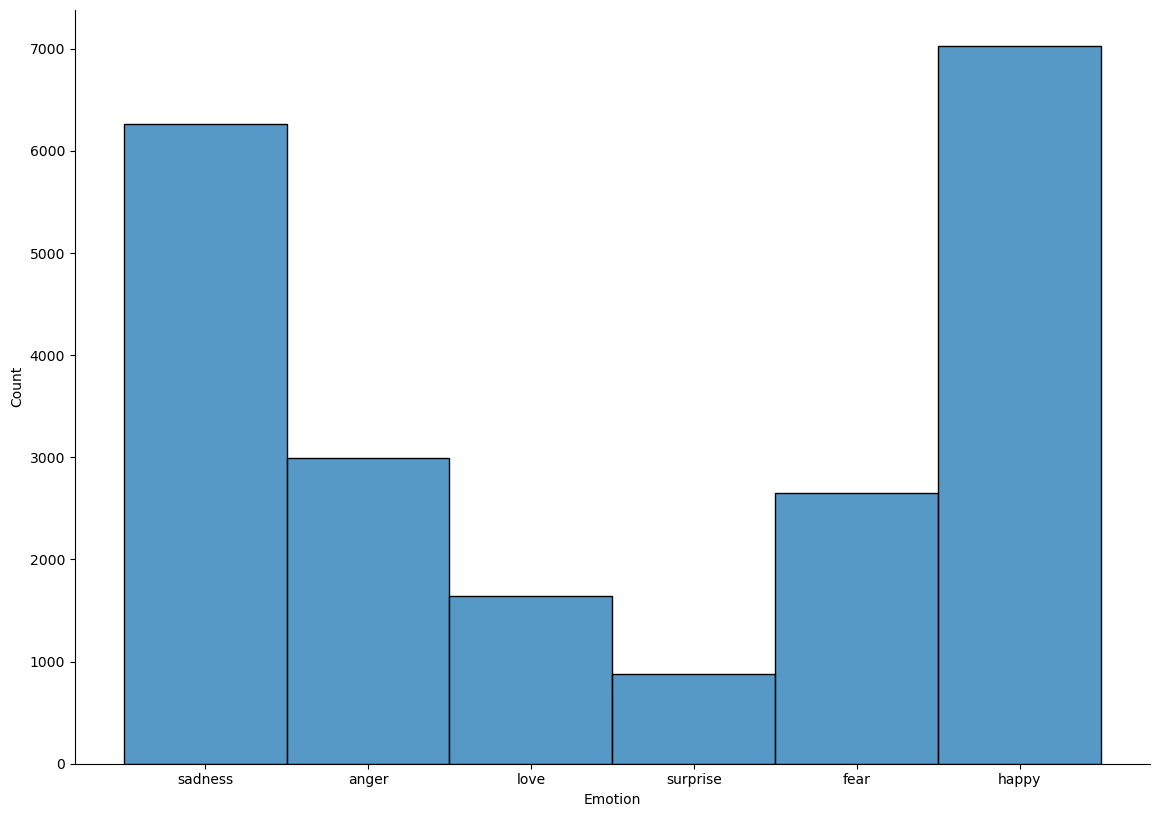

In [99]:
sns.displot(df['Emotion'], height=8.27, aspect=11.7/8.27)

In [100]:
df = df.dropna()

A pesar de haber perdido la posibilidad de tener de obtener ciertos sentimientos, esto sucedio puesto que el dataset estaba muy desequilibrado, dando unicamente buenos resultados en 'Worry' y 'Neutral', por lo que tambien se le bajo la cantidad de datos que coincidian con ese resultado

In [101]:
stop_words = set(stopwords.words('english')) 
def removeStopwordsAndLower(text):
    
    words = text.lower().split() 
    filtered_words = [word for word in words if word not in stop_words] 
    return ' '.join(filtered_words)

df['Text'] = df['Text'].apply(removeStopwordsAndLower)


In [102]:
df

,Text,Emotion
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger
...,...,...
21454,melissa stared friend dism,fear
21455,successive state elections seen governing part...,fear
21456,vincent irritated dismay,fear
21457,kendall-hume turned back face dismayed coup,fear


In [119]:
def lemaAndStem(text):
    stemmer = SnowballStemmer("english")
    wnl = WordNetLemmatizer()
    normalized_text = []
    for word in text.split():
        stemmed_word = stemmer.stem(word)
        stemmed_word = wnl.lemmatize(stemmed_word)
        normalized_text.append(stemmed_word)
    return ' '.join(normalized_text).replace(',', '')

df['Text'] = df['Text'].apply(lemaAndStem)

In [104]:
df

,Text,Emotion
0,didnt feel humili,sadness
1,go feel hopeless damn hope around someon care ...,sadness
2,im grab minut post feel greedi wrong,anger
3,ever feel nostalg fireplac know still properti,love
4,feel grouchi,anger
...,...,...
21454,melissa stare friend dism,fear
21455,success state elect seen govern parti pummel d...,fear
21456,vincent irrit dismay,fear
21457,kendall-hum turn back face dismay coup,fear


Text(0, 0.5, 'Frecuencia')

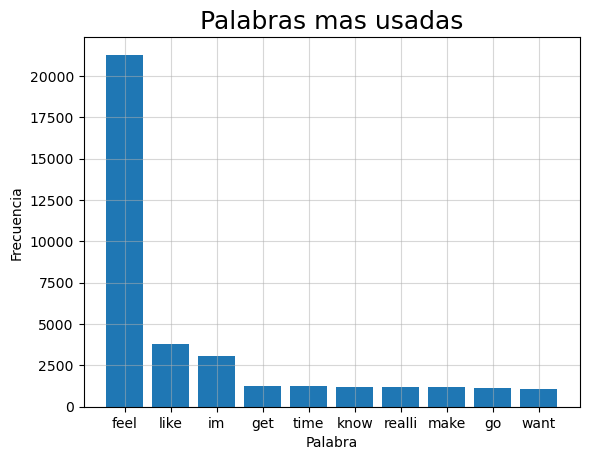

In [105]:
words = []
for text in df['Text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))


plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')

plt.xticks(range(len(top_words)), list(top_words.keys()))

plt.grid(alpha = 0.5)

plt.title('Palabras mas usadas', fontsize = 18)
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')

In [106]:
x = df['Text']#.head(2000)
y = df['Emotion'].replace(['anger', 'fear' ,'happy' ,'love' ,'sadness', 'surprise'], [0, 1, 2, 3, 4, 5])#.head(2000)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

In [107]:
count_vect = CountVectorizer()
vcModel = count_vect.fit(X_train)

X_train_counts = vcModel.transform(X_train)
X_test_counts = vcModel.transform(X_test)

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)

X_train = tf_transformer.transform(X_train_counts)
X_test = tf_transformer.transform(X_test_counts)

In [108]:
pickle.dump(vcModel, open('transformModel_vcModel.pkl', 'wb'))
pickle.dump(tf_transformer, open('transformModel_tf_transformer.pkl', 'wb'))

# Grid Search

In [15]:
parameters = {
    'learning_rate':[1, 0.5, 0.1, 0.05], 
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 6, 8, 10]
}
brt = XGBClassifier()
clf = GridSearchCV(estimator=brt, param_grid=parameters, cv= 2)
clf.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [1, 0.5, 0.1, 0.05],
                         'max_depth': [3, 6, 8, 10],
                         'n_estimators': [150, 200, 250]})

In [16]:
parameters2 = {
    'criterion':['gini', 'entropy', 'log_loss'], 
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 4, 6, 10]
}
brt2 = RandomForestClassifier()
clf2 = GridSearchCV(estimator=brt2, param_grid=parameters2, cv= 2)
clf2.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 4, 6, 10],
                         'n_estimators': [100, 150, 200, 250]})

In [17]:
print('CGBoost best params:      ' ,clf.best_params_)
print('Random Forets best params:' ,clf2.best_params_)

CGBoost best params:       {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 200}
Random Forets best params: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 200}


# Modelo Final

In [125]:
model = XGBClassifier(learning_rate=0.5, n_estimators=200,max_depth= 3 )
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [110]:
model2= RandomForestClassifier(criterion = 'gini', max_depth = None, n_estimators = 200)
model2.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [121]:
print('XGBoost score:     ', model.score(X_test, y_test))
print('Random Fores score:', model2.score(X_test, y_test))

XGBoost score:      0.8613699906803355
Random Fores score: 0.8520503261882573


# Validacion del modelo

[Text(0.5, 0, 'Predecido'),
 Text(0, 0.5, 'Verdadero'),
 Text(0.5, 1.0, 'Matriz de confision modelo XGBoost')]

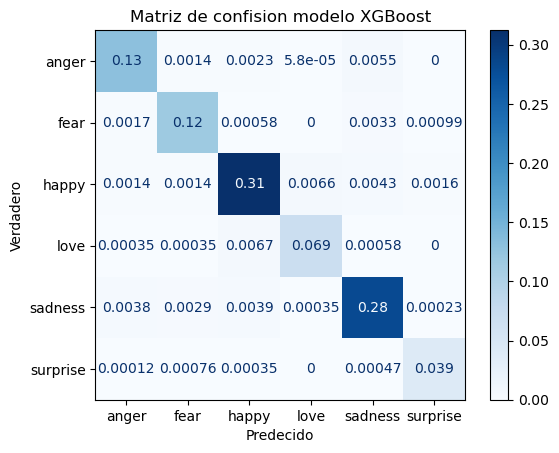

In [122]:
cm = confusion_matrix(y_train, model.predict(X_train), normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['anger', 'fear' ,'happy' ,'love' ,'sadness', 'surprise'])
cmd.plot(cmap=plt.cm.Blues)
cmd.ax_.set(xlabel='Predecido', ylabel='Verdadero', title='Matriz de confision modelo XGBoost')

[Text(0.5, 0, 'Predecido'),
 Text(0, 0.5, 'Verdadero'),
 Text(0.5, 1.0, 'Matriz de confision modelo Random Forest')]

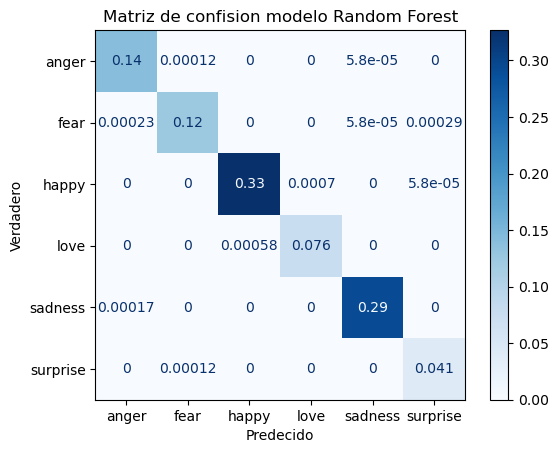

In [113]:
cm = confusion_matrix(y_train, model2.predict(X_train), normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['anger', 'fear' ,'happy' ,'love' ,'sadness', 'surprise'])
cmd.plot(cmap=plt.cm.Blues)
cmd.ax_.set(xlabel='Predecido', ylabel='Verdadero', title='Matriz de confision modelo Random Forest')

In [114]:
modelResult1 = ['XGBoost: ']
modelResult2 = ['Random Forest: ']

predictions = model.predict(X_test)
predictions2 = model2.predict(X_test)

modelResult1.append(f1_score(y_test, predictions, average='weighted'))
modelResult2.append(f1_score(y_test, predictions2, average='weighted'))

modelResult1.append(recall_score(y_test, predictions, average='macro'))
modelResult2.append(recall_score(y_test, predictions2, average='macro'))

modelResult1.append(precision_score(y_test, predictions, average='macro'))
modelResult2.append(precision_score(y_test, predictions2, average='macro'))

pd.DataFrame([modelResult1, modelResult2], columns=['Model', 'F1 score', 'Recall score', 'Precision_score']) 

,Model,F1 score,Recall score,Precision_score
0,XGBoost:,0.860557,0.819045,0.832109
1,Random Forest:,0.851046,0.804203,0.821435


In [115]:
pd.DataFrame([['XGBoost', *recall_score(y_test, predictions, average=None)], 
              ['Random Forest', *recall_score(y_test, predictions2, average=None)]], 
             columns=['Model', 'anger', 'fear' ,'happy' ,'love' ,'sadness', 'surprise']) 

,Model,anger,fear,happy,love,sadness,surprise
0,XGBoost,0.814691,0.850943,0.903272,0.695122,0.900239,0.750000
1,Random Forest,0.834725,0.832075,0.903272,0.664634,0.880287,0.710227


In [116]:
def transformToPredict(textPredict):
    textPredict = removeStopwordsAndLower(textPredict)
    textPredict = lemaAndStem(textPredict)
    textPredict = vcModel.transform([textPredict])
    textPredict = tf_transformer.transform(textPredict)
    return textPredict

In [117]:
# text = input('Escribe un texto en ingles: ')
text = 'I like to running'
text = removeStopwordsAndLower(text)
text = lemaAndStem(text)
text = vcModel.transform([text])
text = tf_transformer.transform(text)

print(model.predict(text)[0])

4


In [126]:
modelFileSave = 'trained_model_XGBoost.pkl'
pickle.dump(model, open(modelFileSave, 'wb'))